# Replication of Saddle-to-Saddle Dynamics in Diagonal Linear Networks<br>
*Pesme, S., & Flammarion, N. (2024). Saddle-to-saddle dynamics in diagonal linear networks*. Journal of Statistical Mechanics Theory and Experiment, 2024(10), 104016. https://doi.org/10.1088/1742-5468/ad65e3*

#### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Button, VBox
import math
from itertools import product, combinations 

## Initialisation and Parameter Values

In [2]:
d = 2 # Dimensions of the input vectors
n = 2 # Number of samples

# Initial values of the weights 
# alpha = 1e-2
# v_0 = np.array([0 for x in range(d)])
# u_0 = math.sqrt(2)*alpha*np.array([1 for x in range(d)])

We generate a dataset for our use. The method of generation is taken from Appendix A

In [3]:
def generate_dataset(n, d):
    # Generate the random parameters for the dataset
    H = np.diag(np.random.rand(d))  # Random diagonal entries for covariance matrix
    beta_star = np.random.randn(d) # Initialize beta^* as a random vector in R^d
    
    # Generate the dataset
    x = np.random.multivariate_normal(np.zeros(d), H, n) # Generate x_i from multivariate normal distribution with mean 0 and covariance H
    y = np.dot(x, beta_star)

    return x, y

# Generate the dataset for fixed H and beta_star
def generate_dataset_fixed_H_beta(n,d,H,beta_star):
    # Generate the dataset
    x = np.random.multivariate_normal(np.zeros(d), H, n) # Generate x_i from multivariate normal distribution with mean 0 and covariance H
    y = np.dot(x, beta_star)

    return x, y

# samples_x, samples_y = generate_dataset(n, d)
# For the sake of consistent results when testing, we will fix the dataset
samples_x = np.array([[1, 0.6], [0.2, 0.8]])
beta = np.array([-0.5, 2])
samples_y = samples_x @ beta

samples_y

array([0.7, 1.5])

---
## Important Functions

### 2-layer Diagonal Linear Network
$ x \mapsto \langle u, \sigma(diag(v)x)\rangle $ <br> 
$x \mapsto \langle \beta, x\rangle$ where $\beta = u \odot v$

$u$ - Output weights <br> 
$\sigma$ - Identity function<br> 
$\text{diag}(v)$ - Inner weights<br> 


### Quadratic Loss Function
$L(\beta) = \frac{1}{2n} \sum_{i=1}^{n} (\langle \beta, x_i\rangle - y_i)^2$<br>
$F(\omega) := L(u \odot v)$


In [4]:
# 2-Layer Diagonal Linear Network
def twolDLN(u,v,x):
    return np.inner(u*v, x) # We use the regression vector here for conciseness

# Quadratic Loss Function
def loss(u,v):
    return (1/2*n)*sum([(twolDLN(u,v,samples_x[i])-samples_y[i])**2 for i in range(n)])

### Potential $\phi_\alpha$ - Hyperbolic Entropy function:
$\phi_\alpha(\Beta) = \frac{1}{2} \sum^d_{i=1}\left( \Beta_i \sinh^{-1}(\frac{\Beta_i}{\alpha^2} - \sqrt{\Beta_i^2 +\alpha^4} + \alpha^2)\right)$

In [5]:
def potential(beta, alpha):
    # Ensure beta is a numpy array
    beta = np.array(beta)
    
    # Calculate the function for each beta_i
    result = 1/2*np.sum([beta[i] * np.arcsinh(beta[i] / alpha**2) - np.sqrt(beta[i]**2 + alpha**4) + alpha**2 for i in range(d)])
    
    return result

---
## Gradient Flow

Minimise loss $F$ (without accelerating time)

$\text{d}w_t = - \nabla F(w_t)\text{d}t$

For Gradient descent:
$w_{t+1} = w_t - \eta \nabla F(w_t)$


#### Calculation $\nabla F$
Consider for now only $u$

$\frac{\partial F}{\partial u} = \frac{1}{2n} \sum_{i=1}^n 2(\langle u \odot v,x_i \rangle - y_i) \cdot \frac{\partial}{\partial u}\langle u \odot v, x_i \rangle$

Since $\langle u \odot v, x_i\rangle = \sum_{j=1}^d (u_j v_j x_{ij})$ then $\frac{\partial}{\partial u_j}\langle u \odot v, x_i\rangle = (v_j x_{ij})$

Therefore
$\frac{\partial F}{\partial u} = \frac{1}{n} \sum_{i=1}^n (\langle u \odot v,x_i \rangle - y_i) \cdot (v \odot x_i )$

Similarly 
$\frac{\partial F}{\partial v} = \frac{1}{n} \sum_{i=1}^n (\langle u \odot v,x_i \rangle - y_i) \cdot (u \odot x_i )$

In [6]:
# Partial Derivative of the Loss Function with respect to w
def nabla_F(u,v):
    nabla_F_u = 1/n * sum([(twolDLN(u,v,samples_x[i])-samples_y[i])*(v*samples_x[i]) for i in range(n)])
    nabla_F_v = 1/n * sum([(twolDLN(u,v,samples_x[i])-samples_y[i])*(u*samples_x[i]) for i in range(n)])
    return nabla_F_u, nabla_F_v, np.concatenate((nabla_F_u, nabla_F_v))

# Gradient Descent
def gradient_descent(u,v,eta):
    nabla_F_u, nabla_F_v, _ = nabla_F(u,v)
    u = u - eta*nabla_F_u
    v = v - eta*nabla_F_v
    return u, v

#### Visualising the Gradient Flow

We are interested in trying to observe the saddle-to-saddle movements that we may expect.
$\beta$ is the parameter that we pay attention to

Things that we expect to notice:
1. As the $\alpha$ approaches 0, the time required to notice the saddle 'jumps' increases (the time taken for a jump remains the same)
1. When $\alpha$ is very close to 0, then $\Beta$ remains at the origin



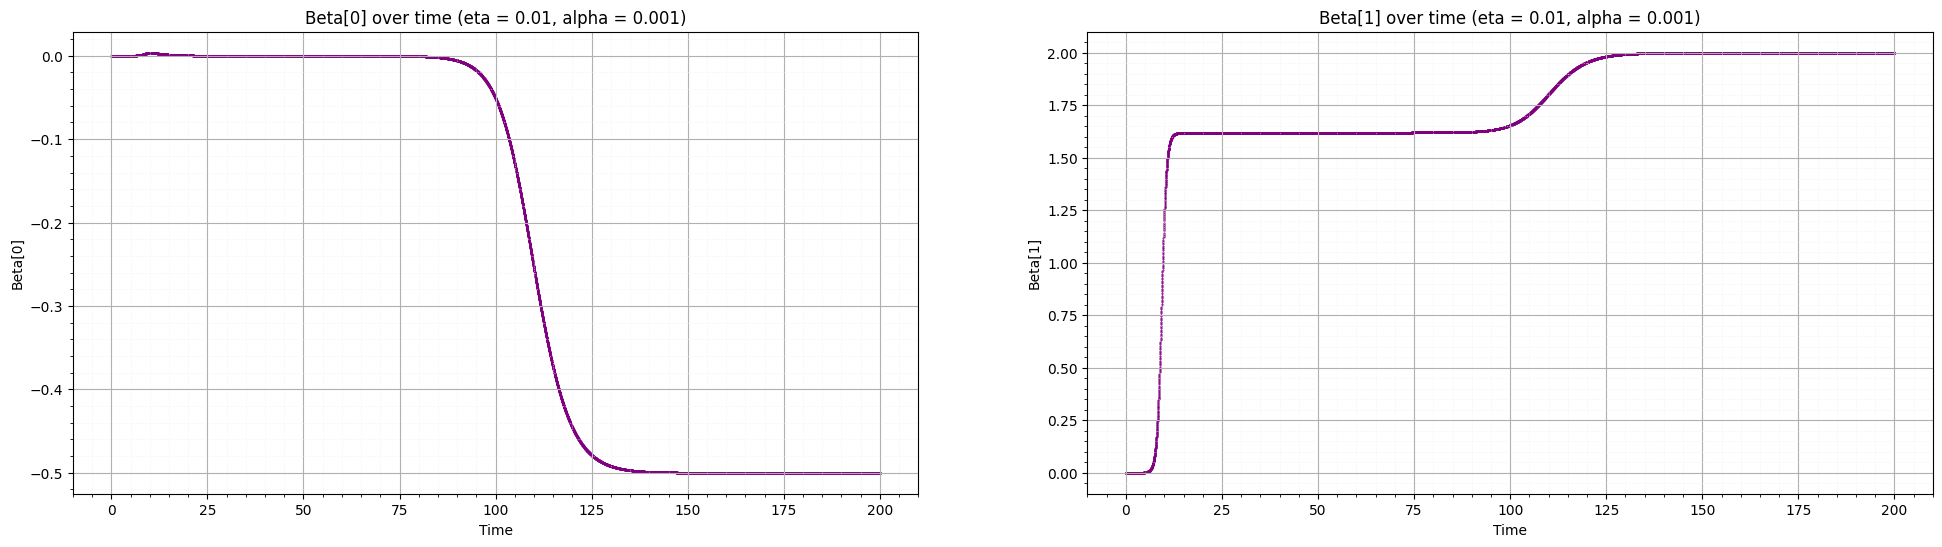

interactive(children=(IntSlider(value=200, description='Time', max=1000, min=50, step=50), FloatSlider(value=0…

<function __main__.plot_gradient_descent(time=200, eta=0.1, alpha=0.1)>

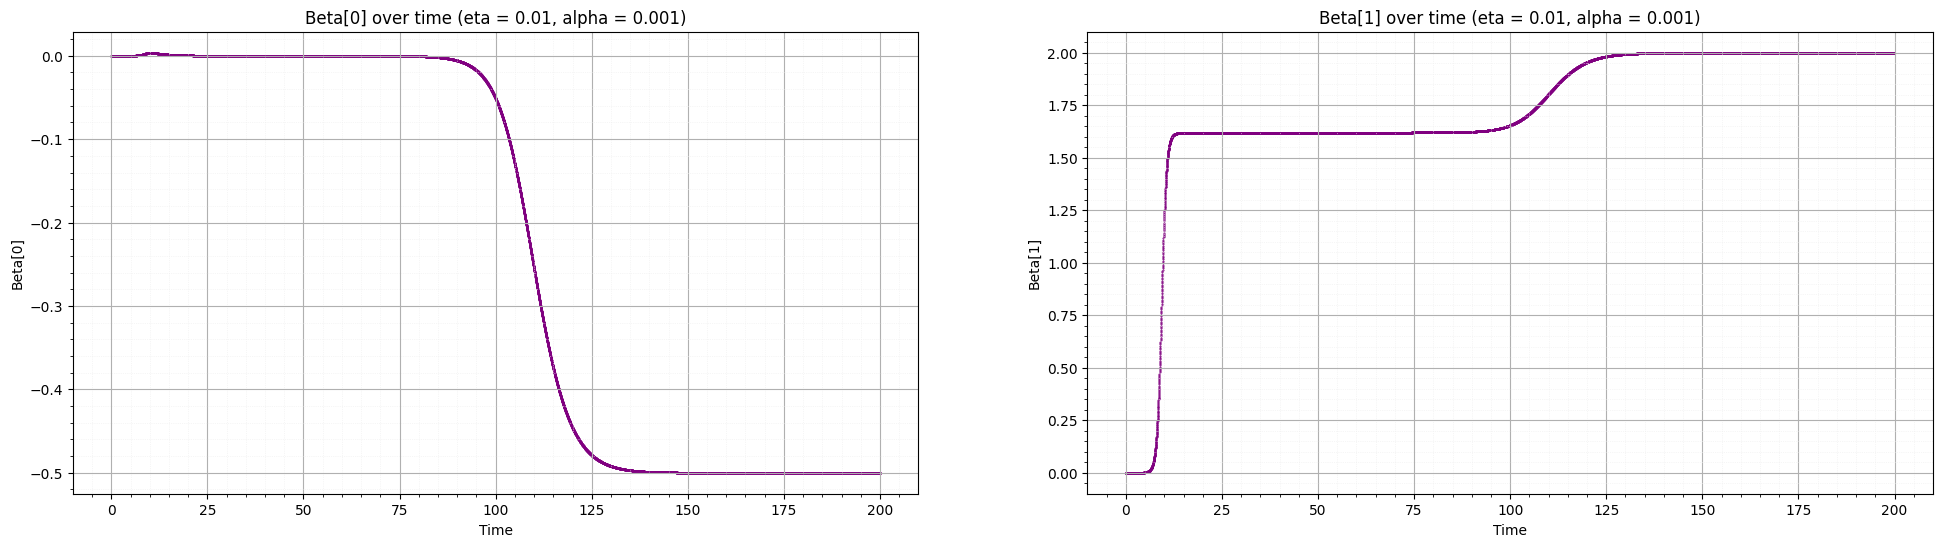

In [ ]:
"""
The following code is used to plot the gradient descent path of beta over time for the 2-layer diagonal linear network.
It will only work for d=2, as the plot is in 2D.
"""

def plot_gradient_descent(time=200,eta=0.1,alpha=1e-1):
    # Number of steps for the gradient descent1
    n_steps = math.floor(time / eta)

    # Initial values of the weights
    v_0 = np.array([0 for x in range(d)])
    u_0 = math.sqrt(2)*alpha*np.array([1 for x in range(d)])

    # Gradient Descent
    u = u_0
    v = v_0
    u_values = [u] # Store the values of u for each iteration
    v_values = [v] # Store the values of v for each iteration
    beta_values = [v*u] # Store the values of beta for each iteration
    potential_values = [potential(v*u, alpha)] # Store the values of the potential for each iteration # TODO: Check if this is at all relevant

    # Perform the gradient descent
    for _ in range(n_steps):
        u, v = gradient_descent(u,v,eta)
        u_values.append(u.copy()) # Save values for plotting
        v_values.append(v.copy()) # Save values for plotting
        beta_values.append(v*u)
        potential_values.append(potential(v*u, alpha))

    # Convert u_values to a numpy array for easier plotting
    u_values = np.array(u_values)
    v_values = np.array(v_values)
    beta_values = np.array(beta_values)
    time_values = np.array([step*eta for step in range(n_steps+1)])
    # Create a figure and two subplots (1 row, 2 columns)
    plt.figure(figsize=(24, 6))

    # First subplot: Gradient descent path for beta[0]
    plt.subplot(1, 2, 1)
    plt.scatter(time_values, beta_values[:, 0], s=0.2, c='purple')
    plt.xlabel('Time')
    plt.ylabel('Beta[0]')
    plt.title(f'Beta[0] over time (eta = {round(eta,5)}, alpha = {round(alpha,5)})')
    plt.grid(True)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    plt.minorticks_on()

    # Second subplot: Gradient descent path for beta[0]
    plt.subplot(1, 2, 2)
    plt.scatter(time_values, beta_values[:, 1], s=0.2, c='purple')
    plt.xlabel('Time')
    plt.ylabel('Beta[1]')
    plt.title(f'Beta[1] over time (eta = {round(eta,5)}, alpha = {round(alpha,5)})')
    plt.grid(which='both')
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    plt.minorticks_on()

    # Save the plot on button click
    def save_plot(_):
        filename = f'plots/BetaPlots_{time}_{round(eta, 5)}_{round(alpha, 5)}.png'
        plt.savefig(filename)

    # Create a button widget
    save_button = Button(description="Save Plot", button_style="success")  # Green button
    save_button.on_click(save_plot)

    # Display the button below the plot
    display(VBox([save_button]))
    plt.show()

# Add sliders to control the parameters
interact(
    plot_gradient_descent,
    time=IntSlider(value=200, min=50, max=1000, step=50, description="Time"),
    eta=FloatSlider(value=0.01, min=0.001, max=0.1, step=0.001, description="Learning Rate",readout_format='.3f'),
    alpha=FloatSlider(value=0.001, min=0.0001, max=0.1, step=0.0001, description="Alpha",readout_format='.4f'),
)



Time Rescaling for the potential

$\tilde{\phi}_\alpha := \frac{1}{\ln(1/\alpha)} \phi_\alpha$

In [8]:
def scaled_potential(beta, alpha):

    # Rescale the hyperbolic entropy
    result = 1/(math.log(1/alpha)) * potential(beta, alpha)
    
    return result

In [9]:
scaled_potential_values = [] # Store the values of the hyperbolic entropy for each iteration
for beta in beta_value:
    scaled_potential_values.append(scaled_potential(beta, alpha))

# Create a figure and two subplots (1 row, 2 columns)
plt.figure(figsize=(12, 6))

# First subplot: Gradient descent path for beta
plt.subplot(1, 2, 1)
plt.scatter(beta_value[:, 0], beta_value[:, 1], s=0.2, c='purple', label='Gradient Descent Path for beta')
plt.scatter(beta_value[0, 0], beta_value[0, 1], c='yellow', label='Initial Value of beta', edgecolors='black')
plt.scatter(beta_value[-1, 0], beta_value[-1, 1], c='green', label='Final Value of beta', edgecolors='black')
plt.xlabel('beta[0]')
plt.ylabel('beta[1]')
plt.title(f'Gradient Descent Path for beta (eta = {eta}, alpha = {alpha})')
plt.legend()
plt.grid(True)

# Second subplot: potential function
plt.subplot(1, 2, 2)
plt.plot(scaled_potential_values, c='orange', label='Scaled Potential Function')
plt.xlabel('Iteration')
plt.ylabel('Scaled Poterntial Function Value')
plt.title(f'Scaled Potential Function (eta = {eta}, alpha = {alpha})')
plt.legend()
plt.grid(True)

plt.show()

NameError: name 'beta_value' is not defined

---
## Assumptions

##### **(Assumption 1) - General Positions**

For any $k \leq \min(n,d)$ and arbitrary signs $\sigma_1, \dots, \sigma_k \in \{-1,1\}$, the affine span of any $k$ points $\sigma \tilde{x}_{j_1}, \ldots, \sigma \tilde{x}_{j_k}$ does not contain any element of the set $\{ \pm \tilde{x_j}, j \neq j_1, \ldots, j_k\}$


In [ ]:
def check_affine_span(X, k):
    """
    Check if the dataset X satisfies the general position assumption.

    Parameters:
    X (numpy array): Dataset with shape (n, d), where n is the number of samples and d is the dimensionality.
                     The ith column of X corresponds to the feature vector x_̃j in the assumption.
    k (int): Number of points to check in the affine span. Must be <= min(n, d).

    Returns:
    bool: True if the assumption holds, False otherwise.

    Warning: 
    This function has exponential complexity in d and k. It is only suitable for small values of d and k.
    """
    # Generate all combinations of k columns and their corresponding sign combinations
    for indices in combinations(range(d), k): # all combinations of k columns
        for signs in product([-1, 1], repeat=k): # all sign combinations
            # Select k columns (corresponding to features) and apply sign changes
            selected_columns = np.array([sign * X[:, idx] for sign, idx in zip(signs, indices)]).T  # Make array of all selected columns and their signs
            
            # Compute the affine span of the selected columns
            # (Affine span is equivalent to checking linear independence after centering the points)
            centered_columns = selected_columns - selected_columns.mean(axis=0) #Centering is necessary for checking the #affine# span not just the linear span
            if np.linalg.matrix_rank(centered_columns) < k:
                continue  # If points are linearly dependent, skip this combination
            
            # Now check if any other columns lie in the affine span
            remaining_indices = [i for i in range(d) if i not in indices] # Columns not in the selected set
            for idx in remaining_indices:
                for sign in [-1, 1]:
                    candidate_column = sign * X[:, idx]
                    augmented_matrix = np.hstack([centered_columns, candidate_column[:, None] - selected_columns.mean(axis=0)])
                    if np.linalg.matrix_rank(augmented_matrix) == k:
                        # If the rank doesn't increase, the point lies in the affine span
                        return False
    
    return True

In [ ]:
k = min(d, n)  # Minimum of d and n for general positions

for i in range(1, k+1):
    if not check_affine_span(samples_x, i):
        print("General position assumption is not satisfied for k = ", i)
    else:
        print("General position assumption is satisfied for k = ", i)

General position assumption is satisfied for k =  1
General position assumption is satisfied for k =  2
